## Importing the required libraries

In [1]:
# !pip install librosa

In [2]:
# !pip install tensorflow

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [4]:
from keras import regularizers

In [5]:
import os

In [6]:
mylist= os.listdir('Audio_Speech_Actors_01-24/')

In [7]:
type(mylist)

list

In [8]:
print(mylist[800])

03-01-05-02-01-02-09.wav


In [9]:
print(mylist[800][18:-4])

09


## Plotting the audio file's waveform and its spectrogram

In [10]:
# data, sampling_rate = librosa.load('RawData/f11 (2).wav')
data, sampling_rate = librosa.load('Audio_Speech_Actors_01-24/03-01-02-01-02-02-02.wav')

Populating the interactive namespace from numpy and matplotlib


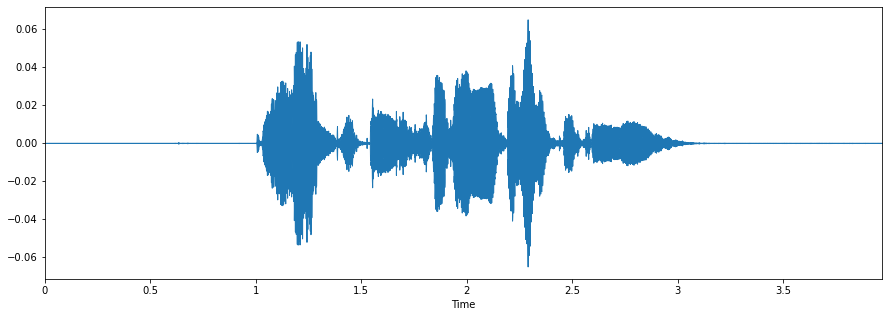

In [11]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

<ipython-input-12-a1709c81f8e2>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('Audio_Speech_Actors_01-24/03-01-05-01-01-01-02.wav')
<ipython-input-12-a1709c81f8e2>:28: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


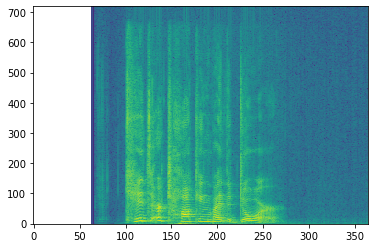

In [12]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys
import pandas as pd


# sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')
sr,x = scipy.io.wavfile.read('Audio_Speech_Actors_01-24/03-01-05-01-01-01-02.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [13]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
#     elif item[:1]=='a':
#         feeling_list.append('male_angry')
#     elif item[:1]=='f':
#         feeling_list.append('male_fearful')
#     elif item[:1]=='h':
#         feeling_list.append('male_happy')
#     #elif item[:1]=='n':
#         #feeling_list.append('neutral')
#     elif item[:2]=='sa':
#         feeling_list.append('male_sad')

In [14]:
labels = pd.DataFrame(feeling_list)

In [15]:
labels[:5]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm


## Getting the features of audio files using librosa

In [16]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
#     print(index,y)
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08':#and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
#         X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)

        X, sample_rate = librosa.load('Audio_Speech_Actors_01-24/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [17]:
df[:5]

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-65.70765, -65.70765, -63.11472, -61.518997, ..."
2,"[-65.4825, -65.4825, -65.4825, -65.4825, -65.4..."
3,"[-64.52845, -64.52845, -64.52845, -64.52845, -..."
4,"[-62.36431, -59.934727, -61.869602, -67.49577,..."


In [18]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [19]:
newdf = pd.concat([df3,labels], axis=1)

In [20]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [21]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661,male_calm
1,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-39.792141,-40.613159,-41.209202,-41.439201,-43.994286,-49.399620,-50.591599,-49.144051,-48.705654,female_calm
2,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-31.346556,-34.310772,-35.800705,-35.936115,-37.631844,-40.119411,-41.662888,-41.323643,-40.710770,male_calm
3,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.674301,-48.596073,-47.602745,-43.049198,-42.659542,-43.188560,-44.001244,-43.610100,-44.698246,female_calm
4,-62.364311,-59.934727,-61.869602,-67.495773,-71.071808,-65.679817,-63.394402,-65.503349,-61.856644,-60.005428,...,-39.071327,-41.897121,-40.865437,-38.290604,-36.372398,-37.915779,-40.026127,-43.383774,-43.965401,male_calm


In [22]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
242,-54.514622,-54.514622,-54.514622,-54.525959,-54.537460,-54.706131,-54.679497,-54.554756,-54.514622,-54.517319,...,-47.733219,-49.022972,-49.438358,-48.091656,-46.473148,-45.532719,-43.895542,-47.092911,-49.495197,male_happy
726,-41.509476,-41.211582,-41.279701,-41.039253,-41.261330,-41.949944,-41.279232,-40.551998,-40.417168,-40.504051,...,-32.731709,-32.707710,-31.940662,-32.185528,-33.970322,-34.747505,-34.679146,-34.679379,-36.013275,male_angry
240,-65.427315,-65.427315,-65.261780,-65.427315,-65.427315,-65.427315,-65.027588,-65.404327,-65.427315,-58.999031,...,-60.775375,-64.036736,-64.463486,-65.204987,-64.805725,-64.463928,-61.400517,-60.954338,-62.738239,male_happy
585,-48.068680,-46.915733,-46.177803,-48.906075,-49.006596,-46.789284,-46.068302,-49.244057,-49.851597,-48.204781,...,-33.916290,-34.231613,-36.540539,-37.225468,-36.283512,-37.516171,-38.178627,-40.013424,-42.205330,female_angry
316,-57.695389,-57.177326,-56.015385,-56.311497,-53.709385,-54.181118,-56.239548,-54.542015,-53.212711,-53.853149,...,-25.633087,-25.042686,-25.086617,-25.839678,-26.986637,-29.418133,-30.673510,-31.521023,-29.729546,male_happy
189,-53.185005,-47.625584,-47.243797,-49.779709,-51.011391,-51.755405,-52.708191,-50.909824,-51.239529,-52.115421,...,-51.702541,-52.720604,-52.037155,-51.598938,-52.916233,-56.010250,-57.615414,-57.382198,-57.939209,female_calm
443,-63.018684,-63.018684,-63.018684,-62.108360,-61.512688,-61.152042,-60.812801,-60.676506,-60.065987,-60.582684,...,-45.491150,-45.851070,-46.737606,-47.816292,-49.592411,-51.432373,-50.115932,-49.081261,-49.202633,female_sad
791,-49.850670,-50.502464,-50.002644,-50.049263,-50.129337,-49.330753,-49.939941,-50.833347,-49.875713,-50.892963,...,-33.824070,-32.726200,-34.279839,-35.941273,-34.481571,-30.942936,-25.977144,-26.224455,-25.959602,female_fearful
403,-78.348274,-78.348274,-78.348274,-78.348274,-78.348274,-78.348274,-78.348274,-78.348274,-78.926430,-76.456818,...,-65.661446,-71.329605,-69.747086,-67.453346,-70.168266,-68.329414,-68.872520,-67.664055,-67.670990,female_sad
607,-46.424908,-46.442383,-47.522541,-47.161766,-47.574402,-49.036720,-49.656685,-50.018898,-49.297421,-48.125217,...,-47.007099,-47.213200,-46.885098,-47.983120,-50.044067,-48.948532,-47.469154,-47.737991,-46.733139,female_angry


In [23]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [24]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
newdf2 = np.random.rand(len(rnewdf)) < 0.2
train = rnewdf[newdf1]
test = rnewdf[~newdf1 + newdf2]

In [25]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
440,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-73.913788,...,-54.464066,-53.316719,-54.589859,-57.332233,-56.584568,-59.388096,-56.328407,-56.053505,-57.214096,male_sad
278,-53.070736,-51.800091,-50.760410,-52.047295,-51.221230,-51.671104,-51.556728,-52.577858,-53.201706,-52.130257,...,-53.811703,-54.319881,-55.268955,-52.052856,-50.433270,-53.498550,-53.312840,-52.798386,-51.479797,male_happy
352,-42.612175,-44.166237,-46.185036,-44.702591,-42.975323,-44.313457,-44.428078,-44.274414,-43.780632,-43.182182,...,-39.133873,-39.412003,-37.712002,-39.044552,-38.289967,-38.845627,-40.895973,-42.518826,-43.199871,male_happy
222,-66.081123,-66.081123,-65.548820,-65.018814,-65.384628,-65.083755,-64.956772,-61.352463,-61.121017,-62.187210,...,-48.056484,-47.372108,-48.898701,-48.729519,-48.319675,-50.189507,-49.494663,-51.268143,-51.128460,male_happy
79,-55.309750,-53.135628,-53.411575,-53.746273,-52.089336,-52.538315,-52.818344,-52.520157,-54.157406,-56.611050,...,-52.228935,-52.653934,-51.813908,-52.422207,-53.317478,-51.357113,-52.184822,-53.723656,-51.837219,female_calm
717,-50.641563,-51.687626,-48.773350,-48.182407,-49.196419,-48.756718,-48.707058,-49.390285,-49.372959,-49.736347,...,-37.328751,-37.398506,-38.638298,-39.988972,-42.318436,-44.127495,-45.311306,-45.131062,-44.633232,female_angry
908,-52.758724,-52.758724,-51.898464,-49.913265,-49.358860,-49.977512,-50.269756,-49.357018,-50.710350,-52.070847,...,-31.759768,-29.112810,-30.303551,-34.929649,-35.643738,-36.025158,-38.403267,-43.493160,-42.363194,male_fearful
503,-55.335274,-55.296867,-55.296867,-55.322285,-55.296867,-55.296867,-55.335293,-55.320072,-55.296867,-55.296867,...,-32.190971,-32.079185,-37.891243,-40.393837,-40.878216,-41.835030,-43.871075,-41.851189,-40.520840,female_sad
713,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,...,-39.483845,-39.880920,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,-39.981865,female_angry
529,-63.937374,-63.937374,-63.937374,-63.937374,-63.937374,-63.937374,-63.937374,-63.937374,-63.937374,-63.937374,...,-60.818462,-63.304623,-63.160069,-60.990055,-60.701374,-59.200783,-57.127094,-58.704929,-63.837456,female_sad


In [26]:
trainfeatures = train.iloc[:, :-1]

In [27]:
trainlabel = train.iloc[:, -1:]

In [28]:
testfeatures = test.iloc[:, :-1]

In [29]:
testlabel = test.iloc[:, -1:]

In [30]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()
# print(y_test.shape)
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [31]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [32]:
X_train.shape

(760, 216)

## Changing dimension for CNN model

In [33]:
from tensorflow.keras import optimizers

In [34]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [35]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))


# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))


model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)

C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout (Dropout)           (None, 216, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                        

In [37]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [38]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
48/48 [==============================] - 2s 40ms/step - loss: 2.5064 - accuracy: 0.1434 - val_loss: 2.2449 - val_accuracy: 0.1466
Epoch 2/700
48/48 [==============================] - 2s 37ms/step - loss: 2.2399 - accuracy: 0.1632 - val_loss: 2.2119 - val_accuracy: 0.1667
Epoch 3/700
48/48 [==============================] - 2s 40ms/step - loss: 2.2104 - accuracy: 0.1592 - val_loss: 2.1766 - val_accuracy: 0.1753
Epoch 4/700
48/48 [==============================] - 2s 38ms/step - loss: 2.1797 - accuracy: 0.1737 - val_loss: 2.1603 - val_accuracy: 0.1839
Epoch 5/700
48/48 [==============================] - 2s 44ms/step - loss: 2.1608 - accuracy: 0.1882 - val_loss: 2.1284 - val_accuracy: 0.2011
Epoch 6/700
48/48 [==============================] - 3s 60ms/step - loss: 2.1335 - accuracy: 0.2079 - val_loss: 2.1161 - val_accuracy: 0.2155
Epoch 7/700
48/48 [==============================] - 3s 56ms/step - loss: 2.1146 - accuracy: 0.2368 - val_loss: 2.0979 - val_accuracy: 0.2356
Epoch 

48/48 [==============================] - 2s 48ms/step - loss: 1.5669 - accuracy: 0.4461 - val_loss: 1.6366 - val_accuracy: 0.4080
Epoch 59/700
48/48 [==============================] - 2s 46ms/step - loss: 1.5682 - accuracy: 0.4224 - val_loss: 1.6336 - val_accuracy: 0.4080
Epoch 60/700
48/48 [==============================] - 2s 47ms/step - loss: 1.5558 - accuracy: 0.4329 - val_loss: 1.6181 - val_accuracy: 0.4109
Epoch 61/700
48/48 [==============================] - 2s 50ms/step - loss: 1.5395 - accuracy: 0.4211 - val_loss: 1.6688 - val_accuracy: 0.3534
Epoch 62/700
48/48 [==============================] - 2s 47ms/step - loss: 1.5389 - accuracy: 0.4553 - val_loss: 1.6018 - val_accuracy: 0.4310
Epoch 63/700
48/48 [==============================] - 2s 46ms/step - loss: 1.5328 - accuracy: 0.4421 - val_loss: 1.6255 - val_accuracy: 0.3966
Epoch 64/700
48/48 [==============================] - 2s 48ms/step - loss: 1.5217 - accuracy: 0.4513 - val_loss: 1.6223 - val_accuracy: 0.3621
Epoch 65/700

48/48 [==============================] - 2s 48ms/step - loss: 1.2943 - accuracy: 0.5184 - val_loss: 1.5415 - val_accuracy: 0.3764
Epoch 116/700
48/48 [==============================] - 2s 48ms/step - loss: 1.2902 - accuracy: 0.5316 - val_loss: 1.4560 - val_accuracy: 0.4569
Epoch 117/700
48/48 [==============================] - 2s 47ms/step - loss: 1.2942 - accuracy: 0.5224 - val_loss: 1.5495 - val_accuracy: 0.3764
Epoch 118/700
48/48 [==============================] - 2s 49ms/step - loss: 1.2906 - accuracy: 0.5342 - val_loss: 1.4580 - val_accuracy: 0.4483
Epoch 119/700
48/48 [==============================] - 2s 50ms/step - loss: 1.2846 - accuracy: 0.5237 - val_loss: 1.4218 - val_accuracy: 0.4483
Epoch 120/700
48/48 [==============================] - 2s 49ms/step - loss: 1.2865 - accuracy: 0.5316 - val_loss: 1.5052 - val_accuracy: 0.4195
Epoch 121/700
48/48 [==============================] - 2s 51ms/step - loss: 1.2806 - accuracy: 0.5224 - val_loss: 1.4292 - val_accuracy: 0.4799
Epoch 

Epoch 172/700
48/48 [==============================] - 3s 64ms/step - loss: 1.1721 - accuracy: 0.5750 - val_loss: 1.3456 - val_accuracy: 0.4885
Epoch 173/700
48/48 [==============================] - 3s 61ms/step - loss: 1.1477 - accuracy: 0.5868 - val_loss: 1.3644 - val_accuracy: 0.5000
Epoch 174/700
48/48 [==============================] - 3s 62ms/step - loss: 1.1584 - accuracy: 0.5776 - val_loss: 1.3573 - val_accuracy: 0.4885
Epoch 175/700
48/48 [==============================] - 3s 58ms/step - loss: 1.1546 - accuracy: 0.5763 - val_loss: 1.4051 - val_accuracy: 0.4828
Epoch 176/700
48/48 [==============================] - 2s 51ms/step - loss: 1.1542 - accuracy: 0.5868 - val_loss: 1.3538 - val_accuracy: 0.4885
Epoch 177/700
48/48 [==============================] - 2s 51ms/step - loss: 1.1421 - accuracy: 0.5724 - val_loss: 1.3401 - val_accuracy: 0.5144
Epoch 178/700
48/48 [==============================] - 3s 53ms/step - loss: 1.1444 - accuracy: 0.5974 - val_loss: 1.3320 - val_accuracy:

Epoch 229/700
48/48 [==============================] - 3s 61ms/step - loss: 1.0467 - accuracy: 0.6250 - val_loss: 1.4802 - val_accuracy: 0.4397
Epoch 230/700
48/48 [==============================] - 3s 61ms/step - loss: 1.0396 - accuracy: 0.6316 - val_loss: 1.3209 - val_accuracy: 0.5230
Epoch 231/700
48/48 [==============================] - 3s 62ms/step - loss: 1.0355 - accuracy: 0.6289 - val_loss: 1.3389 - val_accuracy: 0.5029
Epoch 232/700
48/48 [==============================] - 3s 64ms/step - loss: 1.0377 - accuracy: 0.6329 - val_loss: 1.3862 - val_accuracy: 0.5201
Epoch 233/700
48/48 [==============================] - 3s 63ms/step - loss: 1.0367 - accuracy: 0.6316 - val_loss: 1.2753 - val_accuracy: 0.5460
Epoch 234/700
48/48 [==============================] - 3s 65ms/step - loss: 1.0295 - accuracy: 0.6408 - val_loss: 1.3752 - val_accuracy: 0.4856
Epoch 235/700
48/48 [==============================] - 3s 65ms/step - loss: 1.0249 - accuracy: 0.6250 - val_loss: 1.2786 - val_accuracy:

Epoch 286/700
48/48 [==============================] - 3s 67ms/step - loss: 0.9373 - accuracy: 0.6882 - val_loss: 1.2414 - val_accuracy: 0.5632
Epoch 287/700
48/48 [==============================] - 3s 68ms/step - loss: 0.9368 - accuracy: 0.6776 - val_loss: 1.2749 - val_accuracy: 0.5316
Epoch 288/700
48/48 [==============================] - 3s 68ms/step - loss: 0.9412 - accuracy: 0.6592 - val_loss: 1.2264 - val_accuracy: 0.5661
Epoch 289/700
48/48 [==============================] - 3s 69ms/step - loss: 0.9322 - accuracy: 0.6671 - val_loss: 1.2857 - val_accuracy: 0.5575
Epoch 290/700
48/48 [==============================] - 3s 68ms/step - loss: 0.9316 - accuracy: 0.6632 - val_loss: 1.2040 - val_accuracy: 0.5718
Epoch 291/700
48/48 [==============================] - 3s 69ms/step - loss: 0.9222 - accuracy: 0.6908 - val_loss: 1.2417 - val_accuracy: 0.5632
Epoch 292/700
48/48 [==============================] - 3s 68ms/step - loss: 0.9315 - accuracy: 0.6829 - val_loss: 1.3520 - val_accuracy:

48/48 [==============================] - 4s 75ms/step - loss: 0.8390 - accuracy: 0.7171 - val_loss: 1.2047 - val_accuracy: 0.5776
Epoch 343/700
48/48 [==============================] - 4s 74ms/step - loss: 0.8324 - accuracy: 0.7105 - val_loss: 1.2381 - val_accuracy: 0.5603
Epoch 344/700
48/48 [==============================] - 3s 73ms/step - loss: 0.8286 - accuracy: 0.7158 - val_loss: 1.1700 - val_accuracy: 0.6034
Epoch 345/700
48/48 [==============================] - 3s 68ms/step - loss: 0.8181 - accuracy: 0.7224 - val_loss: 1.1915 - val_accuracy: 0.5948
Epoch 346/700
48/48 [==============================] - 3s 66ms/step - loss: 0.8222 - accuracy: 0.7237 - val_loss: 1.1519 - val_accuracy: 0.6034
Epoch 347/700
48/48 [==============================] - 3s 67ms/step - loss: 0.8252 - accuracy: 0.7197 - val_loss: 1.1641 - val_accuracy: 0.6034
Epoch 348/700
48/48 [==============================] - 3s 68ms/step - loss: 0.8197 - accuracy: 0.7184 - val_loss: 1.1907 - val_accuracy: 0.5661
Epoch 

Epoch 399/700
48/48 [==============================] - 3s 68ms/step - loss: 0.7343 - accuracy: 0.7605 - val_loss: 1.1836 - val_accuracy: 0.6006
Epoch 400/700
48/48 [==============================] - 3s 67ms/step - loss: 0.7297 - accuracy: 0.7737 - val_loss: 1.1704 - val_accuracy: 0.5948
Epoch 401/700
48/48 [==============================] - 3s 67ms/step - loss: 0.7287 - accuracy: 0.7684 - val_loss: 1.1089 - val_accuracy: 0.6178
Epoch 402/700
48/48 [==============================] - 3s 67ms/step - loss: 0.7354 - accuracy: 0.7500 - val_loss: 1.1405 - val_accuracy: 0.6121
Epoch 403/700
48/48 [==============================] - 3s 68ms/step - loss: 0.7306 - accuracy: 0.7592 - val_loss: 1.1878 - val_accuracy: 0.5862
Epoch 404/700
48/48 [==============================] - 3s 68ms/step - loss: 0.7212 - accuracy: 0.7553 - val_loss: 1.1348 - val_accuracy: 0.6293
Epoch 405/700
48/48 [==============================] - 3s 68ms/step - loss: 0.7156 - accuracy: 0.7697 - val_loss: 1.2020 - val_accuracy:

Epoch 456/700
48/48 [==============================] - 3s 68ms/step - loss: 0.6354 - accuracy: 0.7895 - val_loss: 1.1073 - val_accuracy: 0.6494
Epoch 457/700
48/48 [==============================] - 3s 69ms/step - loss: 0.6378 - accuracy: 0.8013 - val_loss: 1.1213 - val_accuracy: 0.6293
Epoch 458/700
48/48 [==============================] - 3s 67ms/step - loss: 0.6331 - accuracy: 0.7961 - val_loss: 1.2639 - val_accuracy: 0.5747
Epoch 459/700
48/48 [==============================] - 3s 68ms/step - loss: 0.6346 - accuracy: 0.7974 - val_loss: 1.1382 - val_accuracy: 0.6092
Epoch 460/700
48/48 [==============================] - 3s 67ms/step - loss: 0.6212 - accuracy: 0.8013 - val_loss: 1.1282 - val_accuracy: 0.6034
Epoch 461/700
48/48 [==============================] - 3s 67ms/step - loss: 0.6236 - accuracy: 0.7921 - val_loss: 1.1048 - val_accuracy: 0.6236
Epoch 462/700
48/48 [==============================] - 3s 66ms/step - loss: 0.6124 - accuracy: 0.8039 - val_loss: 1.2280 - val_accuracy:

48/48 [==============================] - 3s 71ms/step - loss: 0.5277 - accuracy: 0.8434 - val_loss: 1.1535 - val_accuracy: 0.6207
Epoch 513/700
48/48 [==============================] - 3s 71ms/step - loss: 0.5376 - accuracy: 0.8316 - val_loss: 1.1107 - val_accuracy: 0.6351
Epoch 514/700
48/48 [==============================] - 3s 67ms/step - loss: 0.5287 - accuracy: 0.8461 - val_loss: 1.0985 - val_accuracy: 0.6207
Epoch 515/700
48/48 [==============================] - 3s 68ms/step - loss: 0.5248 - accuracy: 0.8355 - val_loss: 1.1002 - val_accuracy: 0.6437
Epoch 516/700
48/48 [==============================] - 3s 65ms/step - loss: 0.5226 - accuracy: 0.8342 - val_loss: 1.1359 - val_accuracy: 0.6092
Epoch 517/700
48/48 [==============================] - 3s 66ms/step - loss: 0.5269 - accuracy: 0.8276 - val_loss: 1.1183 - val_accuracy: 0.6236
Epoch 518/700
48/48 [==============================] - 3s 68ms/step - loss: 0.5292 - accuracy: 0.8447 - val_loss: 1.1658 - val_accuracy: 0.6293
Epoch 

Epoch 569/700
48/48 [==============================] - 4s 87ms/step - loss: 0.4266 - accuracy: 0.8882 - val_loss: 1.1685 - val_accuracy: 0.6149
Epoch 570/700
48/48 [==============================] - 4s 92ms/step - loss: 0.4440 - accuracy: 0.8526 - val_loss: 1.0932 - val_accuracy: 0.6609
Epoch 571/700
48/48 [==============================] - 5s 101ms/step - loss: 0.4382 - accuracy: 0.8776 - val_loss: 1.1559 - val_accuracy: 0.6149
Epoch 572/700
48/48 [==============================] - 5s 98ms/step - loss: 0.4446 - accuracy: 0.8645 - val_loss: 1.0930 - val_accuracy: 0.6695
Epoch 573/700
48/48 [==============================] - 5s 98ms/step - loss: 0.4255 - accuracy: 0.8763 - val_loss: 1.1074 - val_accuracy: 0.6609
Epoch 574/700
48/48 [==============================] - 4s 91ms/step - loss: 0.4322 - accuracy: 0.8803 - val_loss: 1.0906 - val_accuracy: 0.6466
Epoch 575/700
48/48 [==============================] - 5s 94ms/step - loss: 0.4324 - accuracy: 0.8803 - val_loss: 1.0839 - val_accuracy

Epoch 626/700
48/48 [==============================] - 3s 56ms/step - loss: 0.3554 - accuracy: 0.9013 - val_loss: 1.1152 - val_accuracy: 0.6724
Epoch 627/700
48/48 [==============================] - 3s 58ms/step - loss: 0.3497 - accuracy: 0.9237 - val_loss: 1.0978 - val_accuracy: 0.6667
Epoch 628/700
48/48 [==============================] - 3s 59ms/step - loss: 0.3508 - accuracy: 0.9105 - val_loss: 1.0901 - val_accuracy: 0.6523
Epoch 629/700
48/48 [==============================] - 3s 60ms/step - loss: 0.3430 - accuracy: 0.9053 - val_loss: 1.1051 - val_accuracy: 0.6695
Epoch 630/700
48/48 [==============================] - 3s 58ms/step - loss: 0.3423 - accuracy: 0.9132 - val_loss: 1.0912 - val_accuracy: 0.6466
Epoch 631/700
48/48 [==============================] - 3s 60ms/step - loss: 0.3484 - accuracy: 0.8895 - val_loss: 1.2030 - val_accuracy: 0.6523
Epoch 632/700
48/48 [==============================] - 3s 61ms/step - loss: 0.3427 - accuracy: 0.9105 - val_loss: 1.0788 - val_accuracy:

Epoch 683/700
48/48 [==============================] - 3s 57ms/step - loss: 0.2648 - accuracy: 0.9408 - val_loss: 1.1113 - val_accuracy: 0.6868
Epoch 684/700
48/48 [==============================] - 3s 62ms/step - loss: 0.2661 - accuracy: 0.9355 - val_loss: 1.1007 - val_accuracy: 0.6810
Epoch 685/700
48/48 [==============================] - 3s 63ms/step - loss: 0.2679 - accuracy: 0.9329 - val_loss: 1.1174 - val_accuracy: 0.6695
Epoch 686/700
48/48 [==============================] - 3s 59ms/step - loss: 0.2593 - accuracy: 0.9447 - val_loss: 1.1200 - val_accuracy: 0.6868
Epoch 687/700
48/48 [==============================] - 3s 60ms/step - loss: 0.2610 - accuracy: 0.9382 - val_loss: 1.2091 - val_accuracy: 0.6552
Epoch 688/700
48/48 [==============================] - 3s 66ms/step - loss: 0.2625 - accuracy: 0.9421 - val_loss: 1.1060 - val_accuracy: 0.6897
Epoch 689/700
48/48 [==============================] - 3s 66ms/step - loss: 0.2589 - accuracy: 0.9408 - val_loss: 1.1393 - val_accuracy:

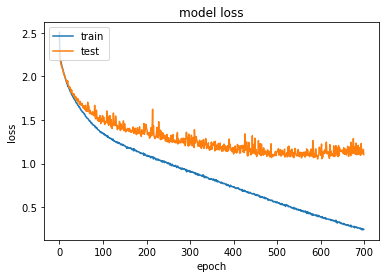

In [39]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [40]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\vidhi.mittal\Documents\Project_final\Speech-Emotion-Analyzer-master\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [41]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [42]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 67.24%


## Predicting emotions on the test data

In [43]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

11/11 [==============================] - 0s 22ms/step


In [44]:
preds

array([[1.7771003e-04, 1.6555762e-09, 2.3501902e-06, ..., 9.1917726e-04,
        2.7676223e-02, 1.0703170e-03],
       [8.0209613e-02, 2.3249283e-02, 2.3601282e-01, ..., 5.7596579e-05,
        3.6878880e-06, 3.2584274e-05],
       [1.1242648e-04, 1.7419094e-01, 5.8170891e-01, ..., 5.2424543e-06,
        3.6373154e-07, 1.3694612e-05],
       ...,
       [3.5506123e-04, 1.8693405e-07, 8.9398319e-01, ..., 2.2056327e-06,
        8.9344851e-11, 1.6834305e-08],
       [5.9831323e-04, 2.1581742e-07, 5.8336542e-07, ..., 4.4198567e-03,
        3.5723884e-02, 5.9042469e-02],
       [2.3446872e-03, 7.7133102e-04, 8.3572147e-03, ..., 1.6762798e-03,
        3.2815083e-03, 2.1758061e-03]], dtype=float32)

In [45]:
preds1=preds.argmax(axis=1)

In [46]:
preds1

array([5, 4, 2, 8, 6, 2, 0, 7, 5, 9, 4, 1, 2, 2, 3, 5, 9, 6, 8, 4, 0, 1,
       7, 3, 7, 2, 6, 4, 0, 0, 3, 9, 7, 0, 8, 5, 9, 0, 6, 6, 6, 0, 5, 4,
       8, 7, 6, 1, 3, 8, 6, 7, 2, 8, 8, 7, 0, 4, 7, 9, 5, 7, 4, 9, 1, 1,
       3, 6, 4, 5, 3, 8, 7, 2, 8, 8, 9, 8, 8, 2, 8, 2, 1, 5, 8, 1, 9, 0,
       3, 3, 9, 3, 7, 4, 1, 9, 2, 5, 6, 2, 3, 0, 7, 1, 0, 5, 3, 4, 6, 9,
       5, 6, 5, 8, 4, 2, 9, 0, 5, 5, 0, 5, 6, 1, 9, 3, 4, 4, 3, 6, 8, 0,
       7, 9, 6, 7, 3, 3, 2, 3, 3, 6, 5, 4, 1, 1, 2, 8, 7, 1, 1, 9, 8, 2,
       7, 3, 3, 6, 8, 6, 5, 1, 5, 0, 3, 9, 3, 4, 2, 8, 4, 5, 2, 4, 6, 6,
       8, 5, 8, 7, 6, 7, 7, 5, 9, 9, 6, 0, 5, 4, 5, 6, 9, 4, 9, 5, 1, 2,
       0, 3, 7, 9, 9, 9, 3, 0, 1, 4, 4, 0, 1, 0, 5, 0, 9, 5, 9, 2, 0, 9,
       9, 6, 9, 3, 8, 0, 3, 1, 2, 1, 0, 9, 1, 7, 2, 2, 3, 9, 3, 3, 7, 0,
       0, 8, 0, 8, 7, 9, 1, 0, 2, 9, 1, 5, 0, 9, 0, 7, 5, 3, 9, 4, 6, 9,
       3, 3, 1, 6, 8, 2, 5, 2, 7, 2, 9, 7, 7, 7, 5, 7, 6, 4, 4, 2, 7, 9,
       0, 2, 1, 8, 9, 9, 1, 9, 9, 0, 8, 7, 7, 8, 9,

In [47]:
abc = preds1.astype(int).flatten()

In [48]:
predictions = (lb.inverse_transform((abc)))

In [49]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_angry
1,female_sad
2,female_fearful
3,male_happy
4,male_calm
5,female_fearful
6,female_angry
7,male_fearful
8,male_angry
9,male_sad


In [50]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [51]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_angry
1,female_fearful
2,female_sad
3,female_angry
4,male_calm
5,female_fearful
6,female_angry
7,male_fearful
8,male_angry
9,male_calm


In [52]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [53]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_calm,female_sad
171,male_angry,male_angry
172,female_fearful,female_fearful
173,female_sad,female_sad
174,male_calm,male_calm
175,male_calm,male_calm
176,male_happy,male_happy
177,male_angry,male_angry
178,male_happy,male_happy
179,male_fearful,male_fearful


In [54]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,32
female_calm,36
female_fearful,36
female_happy,40
female_sad,30
male_angry,32
male_calm,32
male_fearful,39
male_happy,31


In [55]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,34
female_calm,31
female_fearful,33
female_happy,37
female_sad,28
male_angry,37
male_calm,29
male_fearful,37
male_happy,35


In [56]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [57]:
data, sampling_rate = librosa.load('output1.wav')

Populating the interactive namespace from numpy and matplotlib


C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


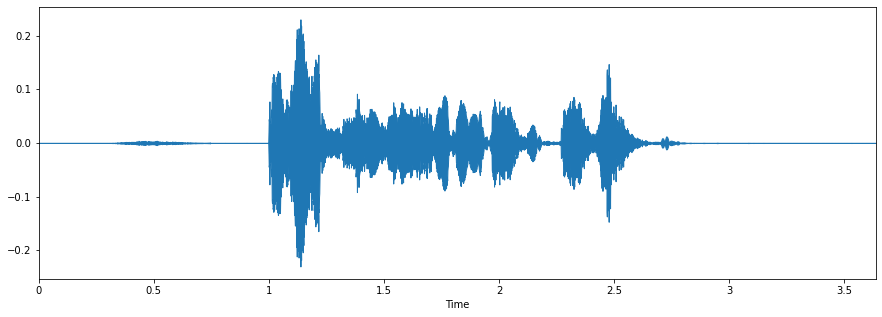

In [58]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [59]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('sample.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [60]:
livedf2= pd.DataFrame(data=livedf2)

In [61]:
livedf2 = livedf2.stack().to_frame().T

In [62]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-24.079884,-22.51935,-27.279818,-28.096218,-27.043488,-25.223715,-25.085512,-25.979271,-27.00415,-26.06381,...,-30.23406,-28.016897,-27.578871,-27.474943,-26.964943,-28.631458,-29.153496,-28.480366,-27.446268,-24.604994


In [63]:
twodim= np.expand_dims(livedf2, axis=2)

In [64]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 20ms/step


In [65]:
livepreds

array([[5.8536842e-03, 2.1410743e-02, 2.9510877e-01, 1.9097159e-02,
        6.5809029e-01, 5.2609117e-09, 1.9659681e-05, 3.9957563e-04,
        1.4725600e-05, 5.4070156e-06]], dtype=float32)

In [66]:
livepreds1=livepreds.argmax(axis=1)

In [67]:
liveabc = livepreds1.astype(int).flatten()

In [68]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['female_sad'], dtype=object)